### TASK A: Top 100 word & Zipf's Law

In [8]:
import pandas as pd

# Load the models and brands mapping
mapping_df = pd.read_csv('car_models_and_brands.csv')

# Load the data from Data Scrapper Code
data_df = pd.read_csv('oldposts_data.csv')

# Create a dictionary for mapping models to brands
model_to_brand = {}
for _, row in mapping_df.iterrows():
    brand = row['Brand']
    models = row['Model'].split('|')
    for model in models:
        model_to_brand[model] = brand

# model_to_brand['s4'] = 'audi'
# model_to_brand['tlx'] = 'acura'
# model_to_brand['awd'] = 'cooper'
# model_to_brand['daytona'] = 'dodge'
# model_to_brand['wrangler'] = 'jeep'

In [9]:
data_df = data_df.drop(columns='Unnamed: 0')

In [10]:
data_df.head()

,User_ID,Date,Comment
0,merc1,Mar-02,I personally think that with a few tweaks the ...
1,fredvh,Mar-02,I am debating a new purchase and these two are...
2,blueguydotcom,Mar-02,"Great handling, RWD, excellent engine and the ..."
3,hungrywhale,Mar-02,And no manual tranny. That may not matter to y...
4,riez,Mar-02,One beauty of BMW 3 Series is that there are s...


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Extract the comment column
comments = data_df[data_df['Comment'].apply(lambda x: isinstance(x, str))]['Comment']

# Tokenize and preprocess the comments (remove punctuation and convert to lowercase)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    return list(set(words))

# Tokenize and preprocess the comments
all_words = []
for comment in comments:
    words = preprocesstext(comment)
    all_words.extend(words)

# Calculate word frequencies
word_frequencies = pd.Series(all_words).value_counts()

In [12]:
print(word_frequencies)

the             5160
a               4385
and             4155
to              4127
i               3961
                ... 
withstand          1
lexan              1
footsteps          1
banglization       1
unpractical        1
Length: 22936, dtype: int64


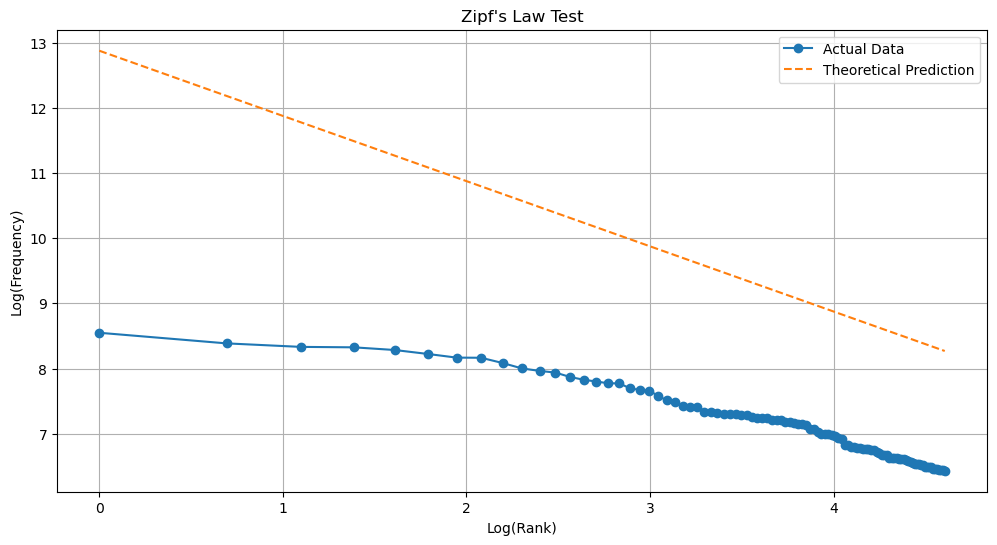

In [14]:
# Calculate word frequencies
word_frequencies = pd.Series(all_words).value_counts()

# Rank words by frequency
ranks = np.arange(1, len(word_frequencies) + 1)

# Calculate the theoretical prediction for Zipf's Law
total_words = len(all_words)
theoretical_freq = total_words / ranks

# Plot the most common 100 words and the theoretical prediction
top_100_words = word_frequencies.head(100)
top_100_ranks = np.arange(1, 101)  # Adjust the ranks to match the top 100 words
plt.figure(figsize=(12, 6))
plt.plot(np.log(top_100_ranks), np.log(top_100_words.values), marker='o', label='Actual Data')
plt.plot(np.log(ranks[:100]), np.log(theoretical_freq[:100]), linestyle='--', label='Theoretical Prediction')
plt.title("Zipf's Law Test")
plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.legend()
plt.grid(True)
plt.show()

### TASK B: Word frequency table after removing stop words

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (you only need to do this once)
nltk.download('stopwords')

# Extract the comment column
comments = data_df[data_df['Comment'].apply(lambda x: isinstance(x, str))]['Comment']

# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    nswords = [model_to_brand.get(word, word) for word in nswords]
    return list(set(nswords))

# Tokenize and preprocess the comments, removing stop words
words_nostop = []
for comment in comments:
    words = preprocesstext(comment)
    words_nostop.extend(words)

# Calculate word frequencies
words_nostop_freq = pd.Series(words_nostop).value_counts()

wnf_df = pd.DataFrame(words_nostop_freq)
wnf_df = wnf_df.reset_index()
wnf_df = wnf_df.rename(columns={'index': 'words', 0: 'frequency'})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
wnf_df.iloc[51:80,:]

,words,frequency
51,many,495
52,right,486
53,years,482
54,doesnt,482
55,infiniti,475
56,cant,470
57,handling,467
58,take,465
59,manual,457
60,ive,455


In [46]:
wnf_df.iloc[61:80,:]

top_10_brand_ls = ['bmw','audi','acura','honda','cooper','volkswagen','dodge','subaru','jeep','toyota']

top_10_df = wnf_df[wnf_df['words'].isin(top_10_brand_ls)]
top_10_df = top_10_df.rename(columns={0: 'frequency'})

print(top_10_df)
wnf_df.to_csv('word_freq.csv')


         words  frequency
2          bmw       1882
7         audi       1521
8        acura       1493
10      cooper       1404
11       honda       1321
46  volkswagen        649
50       dodge        634
51        jeep        633
63      subaru        560
67      toyota        547


### TASK C: LIFT Analysis

In [9]:
token_df = pd.DataFrame(comments)
token_df['Tokenized_Message'] = token_df['Comment'].map(preprocesstext)

def replace_words_in_list(word_list, replacements):
    ls = [replacements.get(word, word) for word in word_list]
    return list(set(ls))

token_df['Mapped_words'] = token_df['Tokenized_Message'].apply(lambda x: replace_words_in_list(x, model_to_brand))


In [10]:
word_distance = 7

def distance_thresh(words_list, word1, word2, max_distance):
    indices_word1 = [i for i, word in enumerate(words_list) if word == word1]
    indices_word2 = [i for i, word in enumerate(words_list) if word == word2]
    for idx1 in indices_word1:
        for idx2 in indices_word2:
            if abs(idx1 - idx2) <= max_distance:
                return True
    return False

def lift_analysis(data,word_A,word_B,max_distance):
    if (word_A == word_B):
        return '-'
    else:
        N = data.shape[0]
        N_A = sum(1 for review in data if word_A in review)
        N_B = sum(1 for review in data if word_B in review)
        N_A_and_B = sum(1 for review in data if distance_thresh(review, word_A, word_B, max_distance) and word_A in review and word_B in review)
    
        lift = (N * N_A_and_B) / (N_A * N_B)

        return np.round(lift,4)

df_lift = []

for index, brand1 in top_10_df.iterrows():
    for index,brand2 in top_10_df.iterrows():
        df_lift.append(lift_analysis(token_df['Mapped_words'],brand1['words'],brand2['words'],word_distance))


In [151]:
import numpy as np
lift_np = np.reshape(df_lift,(10,10))
lift_df = pd.DataFrame(data= lift_np)
for i in range(10):
    lift_df = lift_df.rename(columns = {i: top_10_df.iloc[i, 0]})
    lift_df = lift_df.rename(index = {i: top_10_df.iloc[i, 0]})
lift_df


,bmw,audi,acura,cooper,honda,volkswagen,dodge,jeep,subaru,toyota
bmw,-,0.1791,0.146,0.9314,0.4173,0.2848,0.0,0.0051,0.0401,0.0176
audi,0.1791,-,0.4622,0.3305,1.0117,1.4633,0.0188,0.0,0.0,0.0218
acura,0.146,0.4622,-,0.4604,0.5383,0.2312,0.0064,0.0,0.2886,0.0222
cooper,0.9314,0.3305,0.4604,-,1.3952,0.5823,0.0474,0.4615,0.0384,0.0707
honda,0.4173,1.0117,0.5383,1.3952,-,0.4745,0.0,0.1803,0.0,0.0334
volkswagen,0.2848,1.4633,0.2312,0.5823,0.4745,-,0.0716,0.0861,0.0,0.0
dodge,0.0,0.0188,0.0064,0.0474,0.0,0.0716,-,0.1954,2.4465,0.7653
jeep,0.0051,0.0,0.0,0.4615,0.1803,0.0861,0.1954,-,0.017,3.0312
subaru,0.0401,0.0,0.2886,0.0384,0.0,0.0,2.4465,0.017,-,0.3545
toyota,0.0176,0.0218,0.0222,0.0707,0.0334,0.0,0.7653,3.0312,0.3545,-


### Task D: MDS Plot

In [153]:
lift_df = lift_df.replace(to_replace='-',value=1)
lift_df = lift_df.astype(float)
lift_df

,bmw,audi,acura,cooper,honda,volkswagen,dodge,jeep,subaru,toyota
bmw,1.0000,0.1791,0.1460,0.9314,0.4173,0.2848,0.0000,0.0051,0.0401,0.0176
audi,0.1791,1.0000,0.4622,0.3305,1.0117,1.4633,0.0188,0.0000,0.0000,0.0218
acura,0.1460,0.4622,1.0000,0.4604,0.5383,0.2312,0.0064,0.0000,0.2886,0.0222
cooper,0.9314,0.3305,0.4604,1.0000,1.3952,0.5823,0.0474,0.4615,0.0384,0.0707
honda,0.4173,1.0117,0.5383,1.3952,1.0000,0.4745,0.0000,0.1803,0.0000,0.0334
volkswagen,0.2848,1.4633,0.2312,0.5823,0.4745,1.0000,0.0716,0.0861,0.0000,0.0000
dodge,0.0000,0.0188,0.0064,0.0474,0.0000,0.0716,1.0000,0.1954,2.4465,0.7653
jeep,0.0051,0.0000,0.0000,0.4615,0.1803,0.0861,0.1954,1.0000,0.0170,3.0312
subaru,0.0401,0.0000,0.2886,0.0384,0.0000,0.0000,2.4465,0.0170,1.0000,0.3545
toyota,0.0176,0.0218,0.0222,0.0707,0.0334,0.0000,0.7653,3.0312,0.3545,1.0000


In [160]:
from sklearn.manifold import MDS

def invert_value(x):
    if x == 0:
        return np.NaN
    return 1/x

lift_df_inv = lift_df.applymap(invert_value)

lift_df_inv = lift_df_inv.replace(to_replace=np.NaN,value=200)

for i in range(len(lift_df_inv)):
    for j in range(len(lift_df_inv)):
            lift_df_inv.iloc[i, j] = lift_df_inv.iloc[i, j] ** 0.2  ## Scaled values to get better MDS distances


lift_df_inv

,bmw,audi,acura,cooper,honda,volkswagen,dodge,jeep,subaru,toyota
bmw,1.000000,1.410525,1.469364,1.014315,1.190996,1.285559,2.885400,2.873995,1.902704,2.243352
audi,1.410525,1.000000,1.166901,1.247860,0.997676,0.926688,2.213953,2.885400,2.885400,2.149358
acura,1.469364,1.166901,1.000000,1.167812,1.131866,1.340301,2.746401,2.885400,1.282156,2.141556
cooper,1.014315,1.247860,1.167812,1.000000,0.935562,1.114219,1.840112,1.167255,1.919260,1.698698
honda,1.190996,0.997676,1.131866,0.935562,1.000000,1.160788,2.885400,1.408643,2.885400,1.973562
volkswagen,1.285559,0.926688,1.340301,1.114219,1.160788,1.000000,1.694406,1.633050,2.885400,2.885400
dodge,2.885400,2.213953,2.746401,1.840112,2.885400,1.694406,1.000000,1.386166,0.836163,1.054954
jeep,2.873995,2.885400,2.885400,1.167255,1.408643,1.633050,1.386166,1.000000,2.258969,0.801082
subaru,1.902704,2.885400,1.282156,1.919260,2.885400,2.885400,0.836163,2.258969,1.000000,1.230486
toyota,2.243352,2.149358,2.141556,1.698698,1.973562,2.885400,1.054954,0.801082,1.230486,1.000000


In [165]:
#perform multi-dimensional scaling
mds = MDS(random_state=0)
scaled_df = mds.fit_transform(lift_df_inv)


/Users/uditdhand/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/uditdhand/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


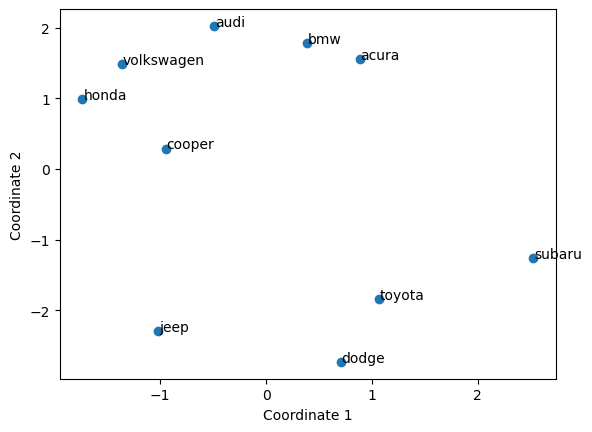

In [166]:
import matplotlib.pyplot as plt

#create scatterplot
plt.scatter(scaled_df[:,0], scaled_df[:,1])

#add axis labels
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')

#add lables to each point
for i, txt in enumerate(top_10_df['words']):
    plt.annotate(txt, (scaled_df[:,0][i]+.01, scaled_df[:,1][i]))

#display scatterplot
plt.show()

### Task F: Attributes

sport
luxury
hybrid
speed
performance
engine
premium
cost
power
interior

In [109]:
top_5_attr = ['sport','luxury','hybrid','speed','performance','engine','premium','cost','power','interior']
top_5_attr_df = wnf_df[wnf_df['words'].isin(top_5_attr)]
top_5_attr_df = top_5_attr_df.rename(columns={0: 'frequency'})

top_5_attr_df

,words,frequency
32,sport,807
33,luxury,798
35,hybrid,787
54,speed,614
83,performance,499
100,engine,451
123,premium,419
156,cost,370
177,power,335
195,interior,315


In [110]:

df_lift_attr = []

for index, brand1 in top_10_df.iterrows():
    for index, attr in top_5_attr_df.iterrows():
        df_lift_attr.append(lift_analysis(token_df['Mapped_words'],brand1['words'],attr['words'],word_distance))

In [111]:
lift_attr_np = np.reshape(df_lift_attr,(10,10))
lift_attr_df = pd.DataFrame(data= lift_attr_np)
for i in range(10):
    lift_attr_df = lift_attr_df.rename(columns = {i: top_10_df.iloc[i, 0]})
    lift_attr_df = lift_attr_df.rename(index = {i: top_5_attr_df.iloc[i, 0]})
lift_attr_df

,bmw,audi,acura,cooper,honda,volkswagen,dodge,jeep,subaru,toyota
sport,0.0993,0.0080,0.0285,1.0962,0.1028,0.0142,0.0459,0.0087,0.2966,0.0000
luxury,0.0000,0.0099,0.0151,0.1227,0.0318,0.0088,0.6058,0.0214,1.5271,0.0252
hybrid,0.0000,0.5063,0.5955,0.0066,0.0486,0.0179,0.7039,0.0218,0.2291,0.1924
speed,0.4898,0.0377,0.0000,0.7067,0.3013,0.0476,0.4922,0.0813,0.5002,0.0000
performance,0.0113,0.0286,0.2611,0.2826,0.0915,0.0000,0.2507,0.0000,1.1586,0.0435
engine,0.3039,0.0000,0.0000,0.0888,0.3459,0.1410,0.8672,0.1964,0.3525,0.0000
premium,0.1651,0.2385,0.0846,0.0000,0.5720,0.7384,0.0000,1.0286,0.0000,0.1208
cost,4.5580,0.0239,0.0363,0.0000,0.8212,0.5916,0.0000,0.5408,0.0000,0.0000
power,0.0133,0.3240,0.1232,0.0000,0.0216,0.2150,0.1028,0.1747,0.0000,0.1710
interior,0.2870,0.2902,0.2943,0.0000,0.5083,0.8802,0.0000,1.4604,0.0000,0.1050
